# Am I the AHole Dataset Construction

Constructing datasets for the AITA subreddit as an exercise using AllenNLP.

In [272]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../aita')

import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact
import statsmodels.api as sm
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

tqdm.pandas()

## Data Loading

Loads the data from sharded files, need to rebuild and concatonate.
May take up a lot of memory, so runon a computer with enough RAM.

In [136]:
train_path = Path.cwd().parent / "aita" / "aita-train.pkl"
test_path = Path.cwd().parent / "aita" / "aita-test.pkl"

In [137]:
train_df = pd.read_pickle(train_path)
test_df = pd.read_pickle(test_path)

In [138]:
train_df.label.value_counts()

NTA    12611
YTA     7448
NAH     1308
ESH      734
Name: label, dtype: int64

In [139]:
test_df.label.value_counts()

NTA    1770
YTA    1019
NAH     175
ESH     106
Name: label, dtype: int64

In [352]:
def add_features(df):
    df['log_num_comments'] = np.log(df.num_comments)
    df['log_score'] = np.log(abs(df.score) + 0.001)
    df['title_len'] = df.title.map(lambda x: len(x.split()))
    df['body_len'] = df.selftext.map(lambda x: len(x.split()))
    df['log_title_len'] = np.log(df.title_len + 0.001)
    df['log_body_len'] = np.log(df.body_len + 0.001)
    df['is_deleted'] = df.selftext == "[deleted]"
    df['is_removed'] = df.selftext == "[removed]"
    return df

In [353]:
train_df = add_features(train_df)
test_df = add_features(test_df)

In [142]:
columns = [a for a in train_df.columns if np.issubdtype(train_df[a].dtype, np.number)]

@interact
def distributions(col=columns):
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=col, y='label', data=train_df)
    plt.show()

interactive(children=(Dropdown(description='col', options=('author_created_utc', 'created_utc', 'downs', 'gild…

## Glove Embeddings

Try simple feedforward NN with glove embeddings.
Will also try some embedding for some nice visualizations.

In [153]:
from sklearn.manifold import TSNE
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.utils.data as data_utils

In [145]:
%%bash
wget -nc http://nlp.stanford.edu/data/glove.6B.zip
unzip -n glove.6B.zip

Archive:  glove.6B.zip


File ‘glove.6B.zip’ already there; not retrieving.



In [146]:
embeddings_dict = {}
with open("glove.6B.300d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [147]:
embedding_size = len(embeddings_dict['at'])

In [148]:
def convert_title_to_embedding(title):
    embeddings = [
        embeddings_dict[word.lower()]
        for word in title.split()
        if word.lower() in embeddings_dict
    ]
    if embeddings:
        glove_embeddings = np.stack(embeddings).mean(axis=0)
    else:
        glove_embeddings = np.zeros(embedding_size)
    return glove_embeddings

In [149]:
train_df['title_emb'] = train_df.title.map(convert_title_to_embedding)
test_df['title_emb'] = test_df.title.map(convert_title_to_embedding)

In [199]:
feature_cols = ['title_emb', 'log_title_len', 'log_body_len', 'num_comments', 'log_num_comments']
features_train = np.array(
    train_df[feature_cols].apply(
        lambda x: np.hstack([np.array(a) for a in x]), axis=1).tolist()
)

In [200]:
tsne = TSNE(n_components=2, verbose=True)
Y = tsne.fit_transform(features_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22101 samples in 0.566s...
[t-SNE] Computed neighbors for 22101 samples in 29.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22101
[t-SNE] Computed conditional probabilities for sample 2000 / 22101
[t-SNE] Computed conditional probabilities for sample 3000 / 22101
[t-SNE] Computed conditional probabilities for sample 4000 / 22101
[t-SNE] Computed conditional probabilities for sample 5000 / 22101
[t-SNE] Computed conditional probabilities for sample 6000 / 22101
[t-SNE] Computed conditional probabilities for sample 7000 / 22101
[t-SNE] Computed conditional probabilities for sample 8000 / 22101
[t-SNE] Computed conditional probabilities for sample 9000 / 22101
[t-SNE] Computed conditional probabilities for sample 10000 / 22101
[t-SNE] Computed conditional probabilities for sample 11000 / 22101
[t-SNE] Computed conditional probabilities for sample 12000 / 22101
[t-SNE] Computed conditional probabilities for sa

In [249]:
train_df['tsne-2d-one'] = Y[:,0]
train_df['tsne-2d-two'] = Y[:,1]

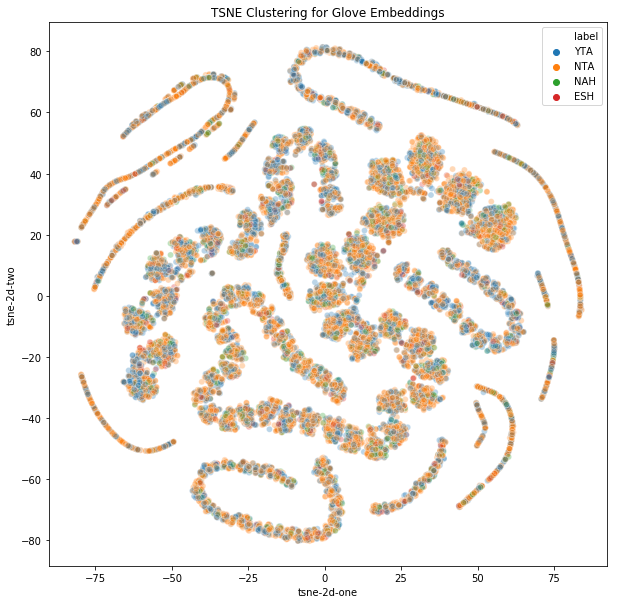

In [255]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    data=train_df,
    legend="full",
    alpha=0.3
)
plt.title("TSNE Clustering for Glove Embeddings")
plt.show()

### Simple Feedforward

In [201]:
feature_cols = ['title_emb', 'log_title_len', 'log_body_len', 'num_comments', 'log_num_comments']

In [202]:
num_classes = train_df.label.nunique()
classes_map = {k: i for i, k in enumerate(train_df.label.unique().tolist())}

In [203]:
train_X = torch.tensor(
    train_df[feature_cols].apply(
        lambda x: np.hstack([np.array(a) for a in x]), axis=1).tolist()
)
test_X = torch.tensor(
    test_df[feature_cols].apply(
        lambda x: np.hstack([np.array(a) for a in x]), axis=1).tolist()
)
train_y = torch.tensor(train_df['label'].map(lambda x: classes_map[x]).tolist())
test_y = torch.tensor(test_df['label'].map(lambda x: classes_map[x]).tolist())

In [204]:
num_features = train_X.size(-1)

In [205]:
train_dataset = data_utils.TensorDataset(train_X, train_y)
test_dataset = data_utils.TensorDataset(test_X, test_y)

train_dataloader = data_utils.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [206]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_dim, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, output_dim)

    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x)
        return x

In [207]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [208]:
model = FeedForward(num_features, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [209]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
    correct_output = []
    predicted_output = []
    for inputs, labels in test_dataloader:
        with torch.no_grad():
            inputs = inputs.to(device).float()
            labels = labels.tolist()
            outputs = model(inputs)
            predicted_output += outputs.cpu().numpy().tolist()
            correct_output += labels
    
    total_testing = len(correct_output)
    total_correct = (np.array(correct_output) == np.array(predicted_output).argmax(axis=-1)).sum()
    print(f"Validation: {total_correct}/{total_testing} = {total_correct/total_testing}")
print('Finished Training')

[1,  2000] loss: 1.053
[1,  4000] loss: 0.971

Validation: 1770/3070 = 0.5765472312703583


[2,  2000] loss: 0.960
[2,  4000] loss: 0.948

Validation: 1783/3070 = 0.5807817589576547


[3,  2000] loss: 0.947
[3,  4000] loss: 0.964

Validation: 1772/3070 = 0.5771986970684039


[4,  2000] loss: 0.957
[4,  4000] loss: 0.943

Validation: 1794/3070 = 0.5843648208469056


[5,  2000] loss: 0.943
[5,  4000] loss: 0.944

Validation: 1785/3070 = 0.5814332247557004


[6,  2000] loss: 0.948
[6,  4000] loss: 0.932

Validation: 1786/3070 = 0.5817589576547231


[7,  2000] loss: 0.928
[7,  4000] loss: 0.942

Validation: 1779/3070 = 0.5794788273615635


[8,  2000] loss: 0.946
[8,  4000] loss: 0.922

Validation: 1788/3070 = 0.5824104234527687


[9,  2000] loss: 0.933
[9,  4000] loss: 0.940

Validation: 1790/3070 = 0.5830618892508144


[10,  2000] loss: 0.928
[10,  4000] loss: 0.927

Validation: 1787/3070 = 0.5820846905537459


[11,  2000] loss: 0.931
[11,  4000] loss: 0.922

Validation: 1775/3070 = 0.5781758957654723


[12,  2000] loss: 0.932
[12,  4000] loss: 0.924

Validation: 1788/3070 = 0.5824104234527687


[13,  2000] loss: 0.939
[13,  4000] loss: 0.910

Validation: 1769/3070 = 0.5762214983713355


[14,  2000] loss: 0.928
[14,  4000] loss: 0.923

Validation: 1788/3070 = 0.5824104234527687


[15,  2000] loss: 0.924
[15,  4000] loss: 0.919

Validation: 1784/3070 = 0.5811074918566775


[16,  2000] loss: 0.927
[16,  4000] loss: 0.918

Validation: 1794/3070 = 0.5843648208469056


[17,  2000] loss: 0.922
[17,  4000] loss: 0.921

Validation: 1772/3070 = 0.5771986970684039


[18,  2000] loss: 0.910
[18,  4000] loss: 0.921

Validation: 1785/3070 = 0.5814332247557004


[19,  2000] loss: 0.907
[19,  4000] loss: 0.914

Validation: 1765/3070 = 0.5749185667752443


[20,  2000] loss: 0.914
[20,  4000] loss: 0.912

Validation: 1791/3070 = 0.5833876221498371
Finished Training


For visualization purposes, let's append the predictions to the test dataframe to see if we can see which mistakes are most common.

In [221]:
test_df.label_fine.head()

23748     {'NTA': 4, 'YTA': 1, 'NAH': 0, 'ESH': 4}
23601    {'NTA': 11, 'YTA': 4, 'NAH': 3, 'ESH': 1}
20210     {'NTA': 5, 'YTA': 0, 'NAH': 1, 'ESH': 0}
19092    {'NTA': 11, 'YTA': 0, 'NAH': 0, 'ESH': 0}
20375     {'NTA': 6, 'YTA': 6, 'NAH': 0, 'ESH': 0}
Name: label_fine, dtype: object

Let's just classify our labels as "sure" or "unsure" based on the aggregate votes.
One way to split this is to check the percentage of the votes for the majority label.

In [222]:
def get_majority_percent_from_dict(fine_labels):
    vals = np.array(list(fine_labels.values()))
    return vals.max() / vals.sum()

In [224]:
test_df['label_maj'] = test_df.label_fine.map(get_majority_percent_from_dict)

[]

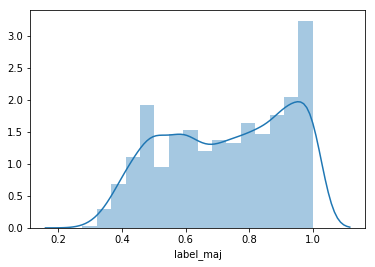

In [228]:
sns.distplot(test_df['label_maj'])
plt.plot()

Therefore, let's put less than 0.5 as unsure, less than 0.75 as kinda unsure, and over 0.75 as sure.

In [229]:
test_df['label_conf'] = test_df['label_maj'].map(
    lambda x: 'very unsure' if x < 0.5 else 'unsure' if x < 0.75 else 'sure')

In [232]:
test_df.label_conf.value_counts()

sure           1549
unsure         1106
very unsure     415
Name: label_conf, dtype: int64

In [233]:
correct_output = np.array(correct_output)
predicted_output = np.array(predicted_output)

In [238]:
test_df['label_pred'] = predicted_output.argmax(axis=-1)
test_df['label_id'] = test_df.label.map(classes_map.get)

In [241]:
test_df['correct'] = test_df['label_pred'] == test_df['label_id']

In [245]:
test_df.groupby('label_conf')['correct'].mean()

label_conf
sure           0.658489
unsure         0.493671
very unsure    0.542169
Name: correct, dtype: float64

In [248]:
test_df.groupby("label_conf").label.value_counts().to_frame()

label
label_conf  label       
sure        NTA      986
            YTA      512
            NAH       35
            ESH       16
unsure      NTA      559
            YTA      377
            NAH      106
            ESH       64
very unsure NTA      225
            YTA      130
            NAH       34
            ESH       26

In [215]:
confusion_matrix(correct_output, predicted_output.argmax(axis=-1))

array([[ 230,  787,    0,    2],
       [ 207, 1561,    0,    2],
       [  29,  146,    0,    0],
       [  18,   88,    0,    0]])

In [ ]:
(np.array(predicted_output).argmax(axis=-1) == np.array(correct_output)).mean()

### Bert Embeddings

In [258]:
from transformers import RobertaModel, RobertaTokenizer

I0313 14:17:01.933348 139968157779776 file_utils.py:41] PyTorch version 1.2.0 available.


In [259]:
model_type = 'roberta-base'
roberta_model = RobertaModel.from_pretrained(model_type)
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_type)

I0313 14:17:33.585898 139968157779776 configuration_utils.py:256] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /home/wfu/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
I0313 14:17:33.587762 139968157779776 configuration_utils.py:292] Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embedd

I0313 14:17:54.133253 139968157779776 file_utils.py:489] storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json in cache at /home/wfu/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
I0313 14:17:54.135217 139968157779776 file_utils.py:492] creating metadata file for /home/wfu/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
I0313 14:17:54.137719 139968157779776 filelock.py:318] Lock 139964707303944 released on /home/wfu/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock


I0313 14:17:54.543780 139968157779776 filelock.py:274] Lock 139964707266232 acquired on /home/wfu/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
I0313 14:17:54.547245 139968157779776 file_utils.py:479] https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt not found in cache or force_download set to True, downloading to /home/wfu/.cache/torch/transformers/tmp_bnmy5n0


I0313 14:17:55.340766 139968157779776 file_utils.py:489] storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt in cache at /home/wfu/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
I0313 14:17:55.343571 139968157779776 file_utils.py:492] creating metadata file for /home/wfu/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
I0313 14:17:55.345736 139968157779776 filelock.py:318] Lock 139964707266232 released on /home/wfu/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
I0313 14:17:55.346988 139968157779776 tokenization_utils.py:501] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /hom

In [318]:
train_df['roberta_tokens_title'] = train_df.title.map(roberta_tokenizer.encode)
test_df['roberta_tokens_title'] = test_df.title.map(roberta_tokenizer.encode)

In [293]:
def get_roberta_embedding_from_tokens(x):
    with torch.no_grad():
        return roberta_model.embeddings(torch.tensor(x).unsqueeze(0)).mean(axis=1)[0].numpy()

In [319]:
train_df['roberta_emb_title'] = train_df.roberta_tokens_title.progress_map(get_roberta_embedding_from_tokens)
test_df['roberta_emb_title'] = test_df.roberta_tokens_title.progress_map(get_roberta_embedding_from_tokens)

In [345]:
help(roberta_tokenizer.encode)

Help on method encode in module transformers.tokenization_utils:

encode(text, text_pair=None, add_special_tokens=True, max_length=None, stride=0, truncation_strategy='longest_first', pad_to_max_length=False, return_tensors=None, **kwargs) method of transformers.tokenization_roberta.RobertaTokenizer instance
    Converts a string in a sequence of ids (integer), using the tokenizer and vocabulary.
    
    Same as doing ``self.convert_tokens_to_ids(self.tokenize(text))``.
    
    Args:
        text: The first sequence to be encoded. This can be a string, a list of strings (tokenized string using
            the `tokenize` method) or a list of integers (tokenized string ids using the `convert_tokens_to_ids`
            method)
        text_pair: Optional second sequence to be encoded. This can be a string, a list of strings (tokenized
            string using the `tokenize` method) or a list of integers (tokenized string ids using the
            `convert_tokens_to_ids` method)
        

In [358]:
train_df.loc[train_df.selftext.map(len) == 0, "selftext"] = "none"
test_df.loc[test_df.selftext.map(len) == 0, "selftext"] = "none"

In [360]:
train_df['roberta_tokens_body'] = train_df.selftext.map(lambda x: roberta_tokenizer.encode(x, max_length=500))
test_df['roberta_tokens_body'] = test_df.selftext.map(lambda x: roberta_tokenizer.encode(x, max_length=500))
train_df['roberta_emb_body'] = train_df.roberta_tokens_body.progress_map(get_roberta_embedding_from_tokens)
test_df['roberta_emb_body'] = test_df.roberta_tokens_body.progress_map(get_roberta_embedding_from_tokens)

In [304]:
feature_cols = ['roberta_emb_title']
features_train = np.array(
    train_df[feature_cols].apply(
        lambda x: np.hstack([np.array(a) for a in x]), axis=1).tolist()
)

In [305]:
tsne = TSNE(n_components=2, verbose=True)
roberta_tsne = tsne.fit_transform(features_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22101 samples in 2.756s...
[t-SNE] Computed neighbors for 22101 samples in 1250.839s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22101
[t-SNE] Computed conditional probabilities for sample 2000 / 22101
[t-SNE] Computed conditional probabilities for sample 3000 / 22101
[t-SNE] Computed conditional probabilities for sample 4000 / 22101
[t-SNE] Computed conditional probabilities for sample 5000 / 22101
[t-SNE] Computed conditional probabilities for sample 6000 / 22101
[t-SNE] Computed conditional probabilities for sample 7000 / 22101
[t-SNE] Computed conditional probabilities for sample 8000 / 22101
[t-SNE] Computed conditional probabilities for sample 9000 / 22101
[t-SNE] Computed conditional probabilities for sample 10000 / 22101
[t-SNE] Computed conditional probabilities for sample 11000 / 22101
[t-SNE] Computed conditional probabilities for sample 12000 / 22101
[t-SNE] Computed conditional probabilities for 

In [306]:
train_df['roberta-tsne-2d-one'] = roberta_tsne[:,0]
train_df['roberta-tsne-2d-two'] = roberta_tsne[:,1]

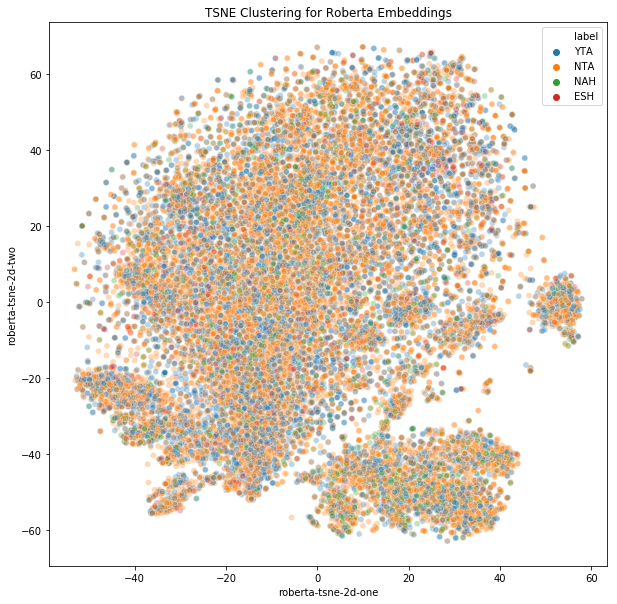

In [307]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="roberta-tsne-2d-one", y="roberta-tsne-2d-two",
    hue="label",
    data=train_df,
    legend="full",
    alpha=0.3
)
plt.title("TSNE Clustering for Roberta Embeddings")
plt.show()

In [383]:
feature_cols = ['roberta_emb_body', 'roberta_emb_title', 'log_title_len', 'log_body_len', 'num_comments', 'log_num_comments',
                'is_deleted', 'is_removed']

In [384]:
from aita_utils import convert_df_to_dataloaders
from aita_utils import train_simple_feedforward
import aita_utils

In [385]:
from importlib import reload
reload(aita_utils)

<module 'aita_utils' from '/home/wfu/harvard/leddit/notebooks/aita_utils.py'>

In [386]:
train_df['label_id'] = train_df.label.map(classes_map.get)
test_df['label_id'] = test_df.label.map(classes_map.get)

In [387]:
train_dataloader = convert_df_to_dataloaders(train_df, feature_cols, 'label_id', shuffle=True, batch_size=32)
test_dataloader = convert_df_to_dataloaders(test_df, feature_cols, 'label_id', shuffle=False, batch_size=1)

In [388]:
for features, label in test_dataloader:
    num_features = features.size(1)
    print(num_features)
    break

1542


In [389]:
trained_model = aita_utils.train_simple_feedforward(train_dataloader, test_dataloader, num_features, 4, epochs=10)


Validation: 1770/3070 = 0.5765472312703583



Validation: 1767/3070 = 0.5755700325732899



Validation: 1795/3070 = 0.5846905537459284



Validation: 1794/3070 = 0.5843648208469056



Validation: 1766/3070 = 0.575244299674267



Validation: 1734/3070 = 0.5648208469055375



Validation: 1794/3070 = 0.5843648208469056



Validation: 1788/3070 = 0.5824104234527687



Validation: 1793/3070 = 0.5840390879478827



Validation: 1495/3070 = 0.48697068403908794
